In [131]:
# Load libraries
import cv2 as cv
import numpy as np
from typing import Tuple, List
from PIL.Image import fromarray
from collections import Counter
from IPython.display import display

## Create static function
def show_img(img_array: np.array) -> display:
    return display(fromarray(img_array))

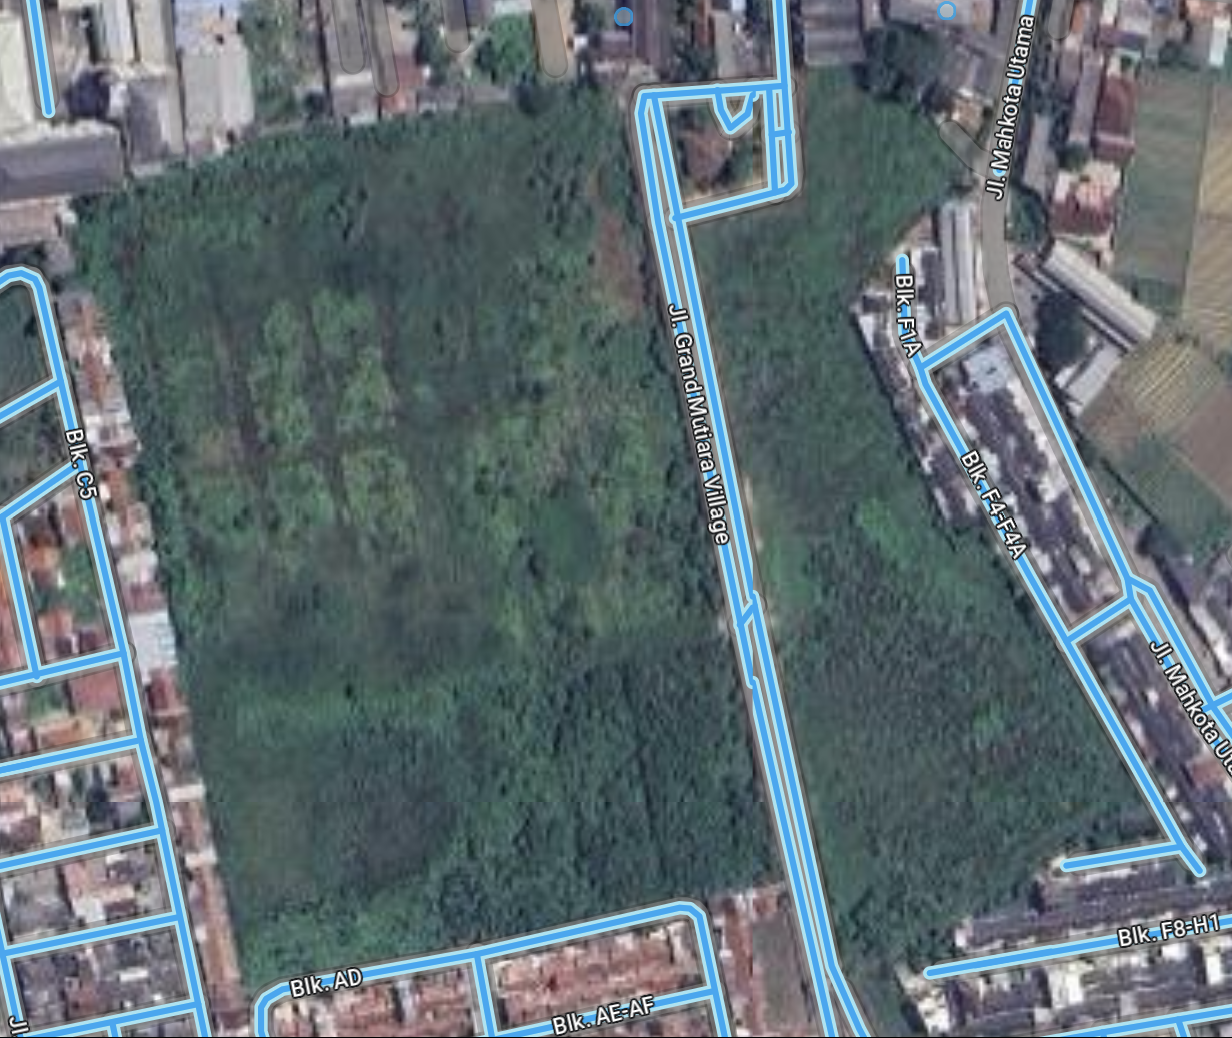

In [143]:
# Read image - RGB Format
image_original = cv.imread("/content/karawang.png")
image_original = cv.cvtColor(image_original, cv.COLOR_BGR2RGB)
show_img(image_original)

In [148]:
# Un-used
# # Define grid masking
# def grid_apply_masking(image: np.array, grid_size: int) -> np.array:
#     result = np.zeros_like(image)
#     h, w, _ = image.shape
#     for y in range(0, h, grid_size):
#         cv.line(result, (0, y), (w, y), (255, 0, 0), 1)
#     for x in range(0, w, grid_size):
#         cv.line(result, (x, 0), (x, h), (255, 0, 0), 1)
#     return result[:, :, 0]

# grid_masking = grid_apply_masking(image_original, 10)
# show_img(grid_masking)

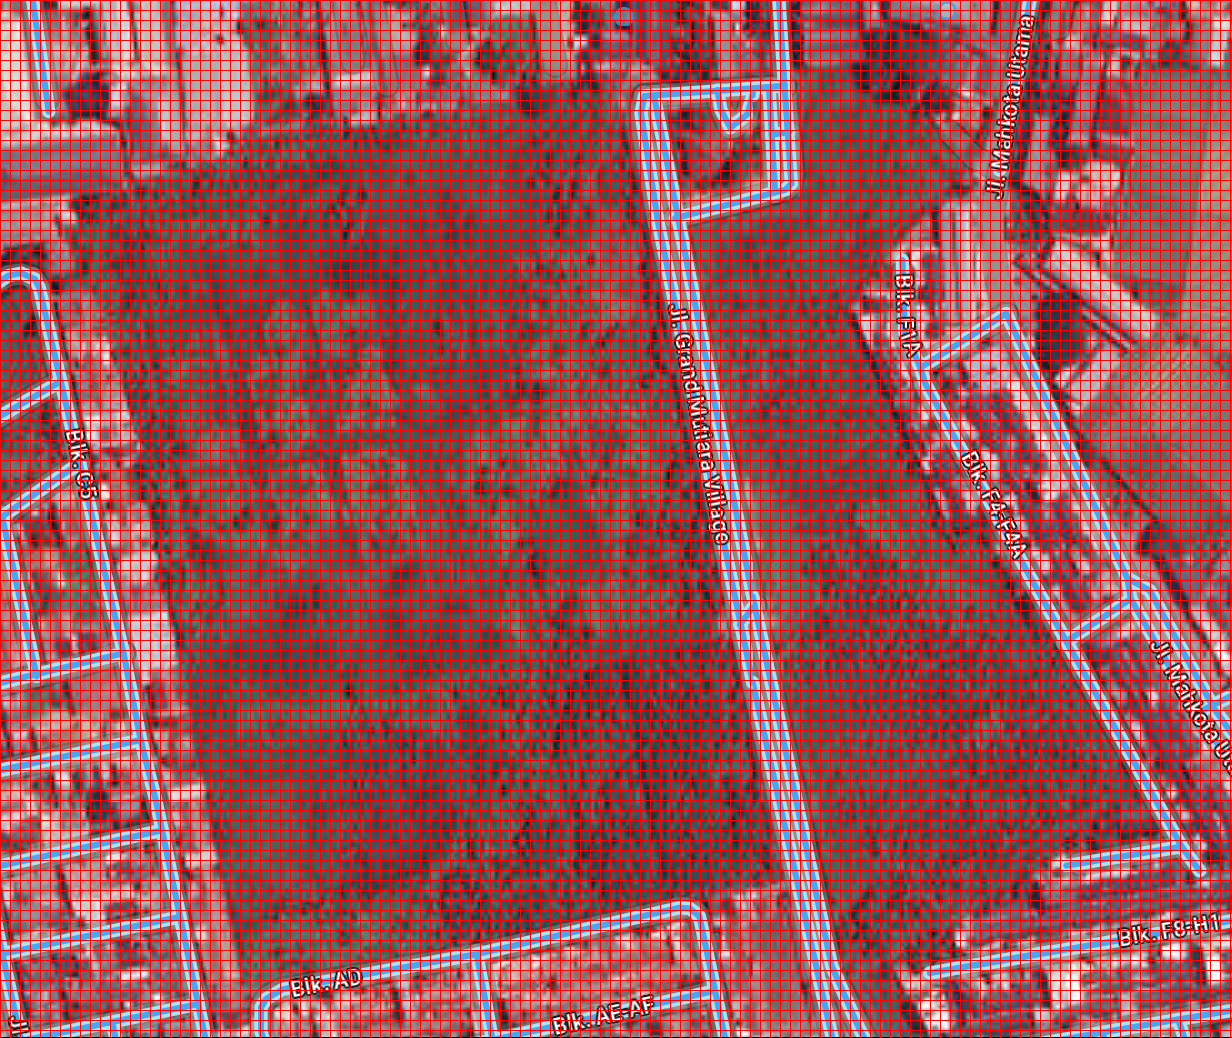

In [145]:
# Define grid masking
def grid_apply(image: np.array, grid_size: int) -> np.array:
    result = image.copy()
    h, w, _ = image.shape
    for y in range(0, h, grid_size):
        cv.line(result, (0, y), (w, y), (255, 0, 0), 1)
    for x in range(0, w, grid_size):
        cv.line(result, (x, 0), (x, h), (255, 0, 0), 1)
    return result

grid_image = grid_apply(image_original, 10)
show_img(grid_image)

Total Area Square: 644,474 Pixel Value


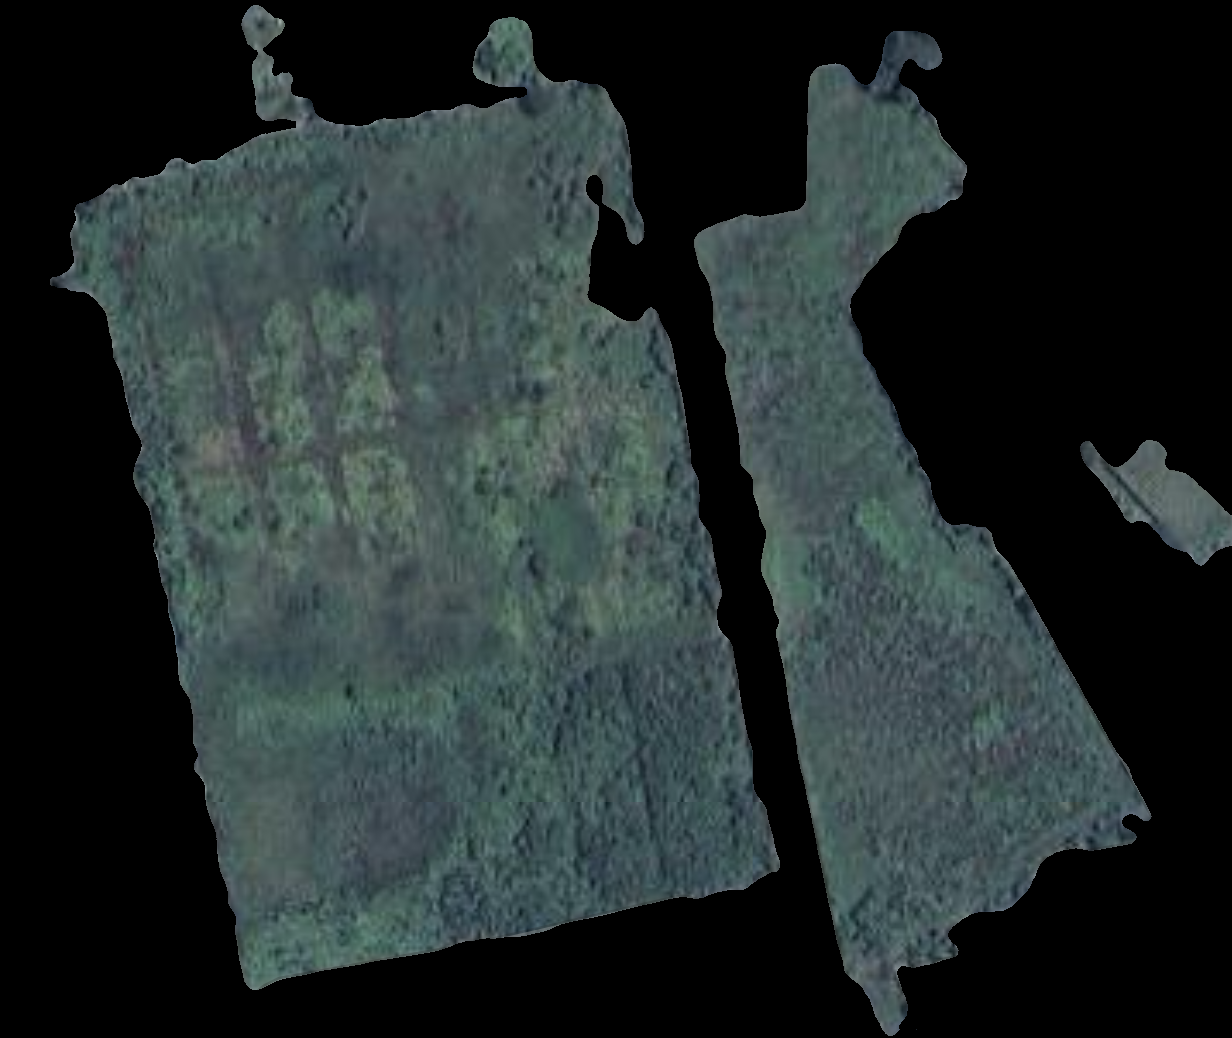

In [155]:
# Define color segmentation method
def segment_green_area(
    image: np.array, is_plant: bool = False,
    lower_bound: np.array = np.array([70, 25, 0]),
    upper_bound: np.array = np.array([105, 255, 125])
    ) -> Tuple[np.array, int]:

    # Masking green area
    image = image.copy()
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    masking = cv.inRange(hsv_image, lower_bound, upper_bound)

    # Contour filter detection
    large_area = np.zeros_like(masking)
    min_area_threshold = []
    contours, _ = cv.findContours(masking, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area_contour = cv.contourArea(contour)
        min_area_threshold.append(area_contour)
    min_area_threshold = sorted(set(min_area_threshold))
    min_area_threshold = np.quantile(min_area_threshold, 0.95)
    final_area_capture = []
    for contour in contours:
        area_contour = cv.contourArea(contour)
        if area_contour >= min_area_threshold:
            final_area_capture.append(int(area_contour))
            cv.drawContours(large_area, [contour], 0, 255, thickness = cv.FILLED)
    if is_plant is False:
        final_area_capture = sum(final_area_capture) # pixel based value

    # Filter result with median filtering
    large_area = cv.medianBlur(cv.cvtColor(large_area, cv.COLOR_GRAY2RGB), 15)[:,:,0]
    result = cv.bitwise_and(image, image, mask = large_area)
    return result, final_area_capture

segmented_area, area_square = segment_green_area(image_original)
print("Total Area Square: {:,} Pixel Value".format(area_square))
show_img(segmented_area)

In [157]:
# Define area plant calculation
def area_plant_calculation(grid_image: np.array) -> Tuple[int, int]:
    _, area_grid_square = segment_green_area(grid_image, is_plant = True)
    area_grid_square = dict(Counter(area_grid_square))
    stable_grid_area = max(area_square_grid, key = area_square_grid.get)
    length_grid_area = area_grid_square[stable_grid_area]
    return stable_grid_area, length_grid_area

stable_grid_area, length_grid_area = area_plant_calculation(grid_image)
print(f"Total Planting Area: {length_grid_area}, Length per Planting: {stable_grid_area} Pixel Value")

Total Planting Area: 5823, Length per Planting: 64 Pixel Value
